In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''') 

# <font color="#E56717">IOBS & IBA Project Update</font>

# <font color="#E56717">October 2016</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')
import os
import collections

preDouble = "\\\\iobsdc01\\SharedDocs\\SEER_MEDICARE\\SEER_MEDICARE_STAGING"
new = os.chdir(preDouble)
#print(preDouble)

In [3]:
df = pd.read_pickle('dfpedsfFirsts.pickle')

# <font color="#E56717">First order of business is to identify all the patients in the SEER-Medicare data who have revceived PBT</font>

<span style="font-size:1.5em;">The relevant HCPCS codes are:</span>

* <span style="font-size:1.5em;">77520 - Proton trmt simple w/o comp</span>
* <span style="font-size:1.5em;">77522 - Proton trmt simle w/comp</span>
* <span style="font-size:1.5em;">77523 - Proton trmt intermediate</span>
* <span style="font-size:1.5em;">77525 - Proton treatment complex</span>

# <font color="#E56717">Use the Outpatient Claims and Carrier Claims files</font>

* <span style="font-size:1.5em;">218 Outpatient Claims files</span>
* <span style="font-size:1.5em;">207 Carrier Claims files</span>

<span style="font-size:1.5em;">Loop through all of these files and capture the set of all the patient_id s corresponding to teh PBT HCPCS codes</span>

## <font color="#E56717">Result:</font>

* <span style="font-size:1.5em;">1605 unique PBT patients appear in the claims files for claims in years 2006-2013</span>

In [4]:
mask = (df['srvm1'] != 9999)
dfall = df[mask]

In [5]:
geomask = (dfall['elevation_1'] != dfall['FIPScombo_1']) 

dfall = dfall[geomask].copy()

In [6]:
dfall['elevation_1'].replace('99999',np.nan,inplace=True)
dfall['elevation_2'].replace('99999',np.nan,inplace=True)
dfall['elevation_3'].replace('99999',np.nan,inplace=True)

dfall['lat_1'].replace('99999',np.nan,inplace=True)
dfall['lat_2'].replace('99999',np.nan,inplace=True)
dfall['lat_3'].replace('99999',np.nan,inplace=True)

dfall['lng_1'].replace('99999',np.nan,inplace=True)
dfall['lng_2'].replace('99999',np.nan,inplace=True)
dfall['lng_3'].replace('99999',np.nan,inplace=True)

dfall['elevation_1'] = dfall['elevation_1'].astype('float')
dfall['elevation_2'] = dfall['elevation_2'].astype('float')
dfall['elevation_3'] = dfall['elevation_3'].astype('float')

dfall['lat_1'] = dfall['lat_1'].astype('float')
dfall['lat_2'] = dfall['lat_2'].astype('float')
dfall['lat_3'] = dfall['lat_3'].astype('float')

dfall['lng_1'] = dfall['lng_1'].astype('float')
dfall['lng_2'] = dfall['lng_2'].astype('float')
dfall['lng_3'] = dfall['lng_3'].astype('float')

In [15]:
import pickle
fileObject = open('patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_outsaf = list(set.union(*b))

In [16]:
import pickle
fileObject = open('patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
treatmentindices_nch = list(set.union(*b))

In [9]:
bigtreatmentindices = list(set(treatmentindices_nch+treatmentindices_outsaf))

dfall.set_index('patient_id', inplace=True,drop=False)

allindices = dfall.index

In [10]:
bigtreatmentset = set(bigtreatmentindices)
allset = set(allindices)


alltreatmentindices = list(allset.intersection(bigtreatmentset))

treatmentindices = alltreatmentindices
#len(treatmentindices)

In [12]:
len(set(treatmentindices))

1605

# <font color="#E56717">Next step is to identify the patients in the SEER-Medicare data who have received any other form of RT</font>

<span style="font-size:1.5em;">Identifying these patients via the SEER data alone proved problematic; half of these patients did not have RT code signatures in the Medicare data.</span>

## <font color="#E56717">Use the following RT treatment delivery codes:</font>

<span style="font-size:1.3em;">['77401','77402','77403','77404','77405','77406','77407','77408','77409','77410','77411','77412','77413',
 '77414','77415','77416','77417','77418','77419','77420','77421','77422','77423','77424','77425','77521',
 '77524','77750','77751','77752','77753','77754','77755','77756','77757','77758','77759','77760','77761',
 '77762','77763','77764','77765','77766','77767','77768','77769','77770','77771','77772','77773','77774',
 '77775','77776','77777','77778','77779','77780','77781','77782','77783','77784','77785','77786','77787',
 '77788','77789','77790','77791','77792','77793','77794','77795','77796','77797','77798','77799','G0173',
 'G0251','G0256','G0261','G0339','G0340']</span>

In [17]:
import pickle
fileObject = open('control_patient_ids_from_outsaf.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_outsaf = list(set.union(*b))

In [18]:
import pickle
fileObject = open('control_patient_ids_from_nch.pickle', 'rb')
b = pickle.load(fileObject)
fileObject.close()
controlindices_nch = list(set.union(*b))

In [19]:
bigcontrolindices = list(set(controlindices_nch+controlindices_outsaf))

In [20]:
bigcontrolset = set(bigcontrolindices)
allset = set(allindices)


allcontrolindices = list(allset.intersection(bigcontrolset))

controlindices = allcontrolindices
#len(treatmentindices)

In [21]:
len(controlindices)

177154

# <font color="#E56717">175878 unique patients had those RT treatment delivery codes (and did not have any PBT codes)</font>


In [22]:
len(treatmentindices)

1605

In [23]:
purecontrolindices = list(set(controlindices) - set(treatmentindices))
len(purecontrolindices)

175878

In [24]:
len(controlindices) - len(purecontrolindices)

1276

# <font color="#E56717">Now use the pedsf files to perform patient matching, using the patient_id s found above</font>

<span style="font-size:1.5em;">List of pedsf files (contains SEER diagnosis year dates 2006-2011):</span>

* pedsf.nasopharynx.cancer.txt
* pedsf.salivary.cancer.txt
* pedsf.oropharynx.cancer.txt
* pedsf.esophagus.cancer.txt
* pedsf.brain.cancer.txt
* pedsf.eyeandorbit.cancer.txt
* pedsf.softtissue.cancer.txt
* pedsf.prostate.cancer.file01.txt
* pedsf.prostate.cancer.file02.txt
* pedsf.prostate.cancer.file03.txt
* pedsf.lung.cancer.file01.txt
* pedsf.lung.cancer.file02.txt
* pedsf.breast.cancer.file01.txt
* pedsf.breast.cancer.file02.txt


# <font color="#E56717">The pedsf files contain one single row for each patient, and contain information for up to 10 different primary tumors</font>

<span style="font-size:1.5em;">So the prostate cancer files contain all patients with a cancer diagnosis where the primary site is the prostate for ANY of the potentially 10 different primary tumors associated with that patient and where that prostate site tumor has a diagnosis date anywhere between 2006 and 2011.</span>

In [25]:
import pedsfhelp

df2 = pedsfhelp.make_clean_dataframe('pedsf.salivarygland.cancer.txt')
#print(df2.shape)

<span style="font-size:1.5em;">For example, in the file pedsf.salivarygland.cancer.txt, the cancer sites for the first tumor listed for each patient has the following distribution:</span>

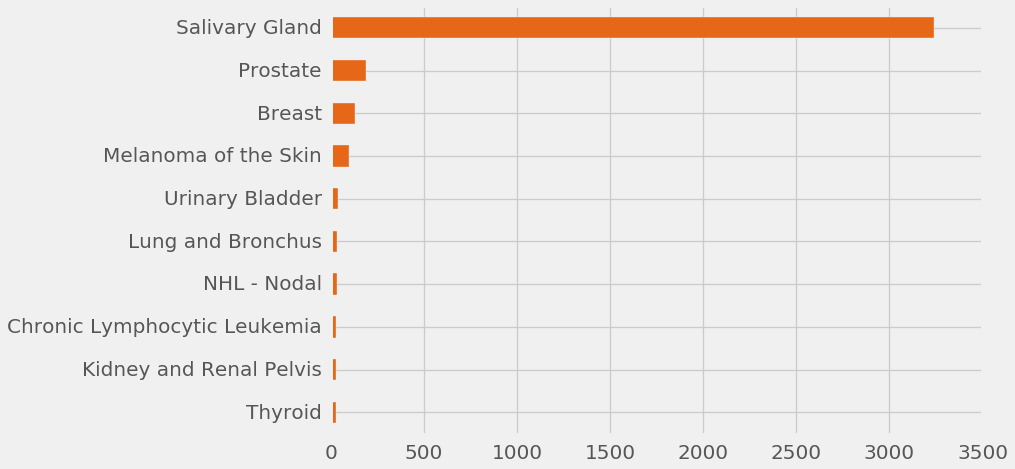

In [26]:
df2.siterwho1.value_counts()[:10][::-1].plot(kind='barh',
                                            color='#E56717');
plt.tick_params(labelsize=20)

# <font color="#E56717">Only keep those patients whose first tumor is at the site indicated in the corresponding file</font>

<span style="font-size:1.5em;">This way we avoid the complications other than the cancer under consideration that may be contributing factors to the outcomes we are analyzing.
Also restrict the analysis to those patients who received some form of radiation treatment for this first diagnosis as indicated by the SEER data.</span>

In [27]:
dfall.patient_id.isin(treatmentindices).sum()

1605

In [28]:
dfall.patient_id.isin(purecontrolindices).sum()

175878

In [29]:
dfall.shape

(719821, 496)

In [30]:
non_rad1 = dfall.rad1.str.contains('None',case=False,na=False)
refused_rad1 = dfall.rad1.str.contains('refused',case=False,na=False)
unknown_rad1 = dfall.rad1.str.contains('unknown',case=False,na=False)

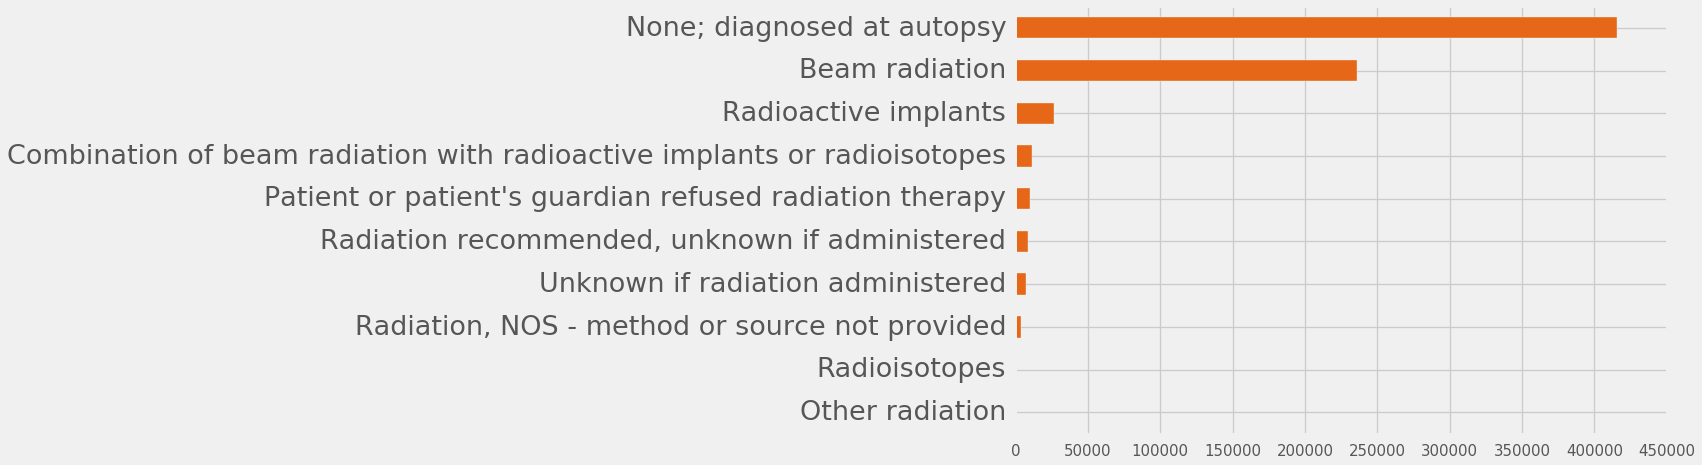

In [31]:
import mpld3
mpld3.disable_notebook()
ax = dfall.rad1.value_counts()[::-1].plot(kind='barh',color='#E56717')
ax.yaxis.set_tick_params(labelsize=27)
ax.xaxis.set_tick_params(labelsize=15)
#plt.tick_params(labelsize=27) # remove the None, refused and unknown group

In [32]:
one = ~non_rad1 & ~refused_rad1 & ~unknown_rad1

had_rad = one

dfsmall = dfall[had_rad].copy()



In [33]:
dfsmall.shape

(278330, 496)

In [34]:
smalltreatmentindices = dfsmall[dfsmall.patient_id.isin(treatmentindices)].index
smallcontrolindices = dfsmall[dfsmall.patient_id.isin(purecontrolindices)].index

In [35]:
smallcontrolindices.shape

(131038,)

In [36]:
smalltreatmentindices.shape


(1200,)

In [37]:
dfalltreatment = dfsmall.loc[smalltreatmentindices].copy()
dfallcontrol = dfsmall.loc[smallcontrolindices].copy()

In [38]:
dfalltreatment.shape, dfallcontrol.shape

((1200, 496), (131038, 496))

# <font color="#E56717">So we are going to match patients who have received PBT (1200 of them) with one of the 131038 patients who have received some other form of radiation. These patients have been identified as receiving RT treatment delivery in both halves of the SEER-Medicare data</font>

<span style="font-size:1.5em;">We first need to decide on which features (or columns) ofthe data to use to define the feature space; and then do some preprocessing of this data ("one-hot-encode" the categorical features)</span>

In [39]:
dfsmall.columns

Index(['casereg', 'patient_id', 'casenumber', 'fivepct', 'medicaredateofdeath',
       'birthm', 'birthyr', 'm_sex', 'race', 'state',
       ...
       'icdot09_1_description', 'icdot09_2_description',
       'icdot09_3_description', 'icdot09_4_description',
       'icdot09_5_description', 'icdot09_6_description',
       'icdot09_7_description', 'icdot09_8_description',
       'icdot09_9_description', 'icdot09_10_description'],
      dtype='object', length=496)

In [40]:
cstum1mask =  (dfsmall['cstum1'] != "Unknown; size not stated; not stated in patient record") & \
(dfsmall['cstum1'] != "Microscopic focus or foci only; no size of focus is given") & \
(dfsmall['cstum1'] != "989 millimeters or larger") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != "Unknown age") & \
(dfsmall['cstum1'] != "Described as less than 1 cm") & \
(dfsmall['cstum1'] != "Described as less than 2 cm") & \
(dfsmall['cstum1'] != "Described as less than 3 cm") & \
(dfsmall['cstum1'] != 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized') & \
(dfsmall['cstum1'] != "Described as less than 4 cm") & \
(dfsmall['cstum1'] != "Described as less than 5 cm") & \
(dfsmall['cstum1'] != "Not applicable") & \
(dfsmall['cstum1'] != 'Not applicable') & \
(dfsmall['cstum1'] != 996) & \
(dfsmall['cstum1'] != 997) & \
(dfsmall['cstum1'] != 998) & \
(dfsmall['srvm1'] != 9999)

# <font color="#E56717">We will not include the variable **cstum1** (the tumor size in mm) for the following reasons:</font>

* <span style="font-size:1.5em;">Egregious measurement error, plots to follow for lung and prostate</span>
* <span style="font-size:1.5em;">Over half of the patients hav emissing values, or text values instead of numbers
    * "Unknown; size not stated; not stated in patient record"
    * "Microscopic focus or foci only; no size of focus is given"
    * "989 millimeters or larger"
    * "Not applicable"
    * "Described as less than 1 cm"
    * "Described as less than 2 cm"
    * "Described as less than 3 cm"
    * 'Indicates no mass or no tumor found; for example, when a tumor of a stated primary site is not found, but the tumor has metastasized'
    * "Described as less than 4 cm"
    * "Described as less than 5 cm"</span>

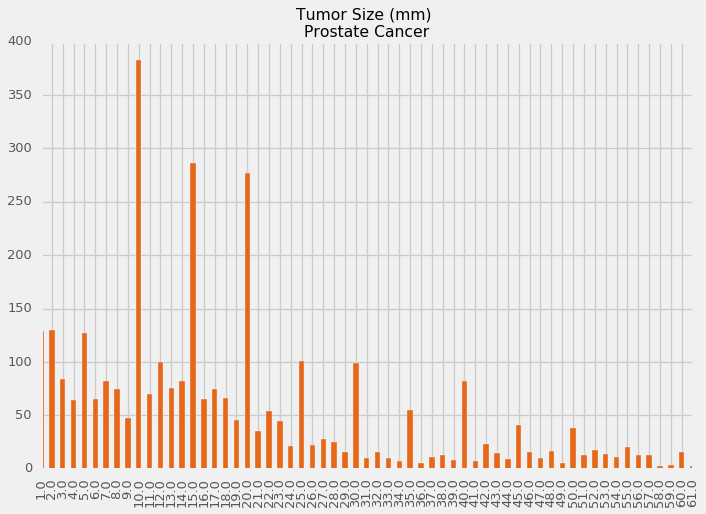

In [41]:
dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("prostate",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nProstate Cancer',color='#E56717');
plt.xlim(0,60);

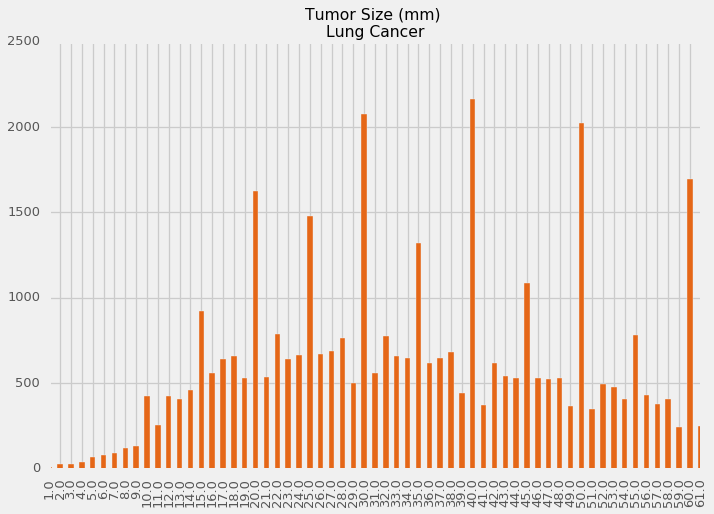

In [42]:
fig1 = plt.figure()
ax = dfsmall[cstum1mask & dfsmall.siterwho1.str.contains("lung",case=False,na=False)].cstum1.value_counts().sort_index().plot(kind='bar',
            title='Tumor Size (mm) \nLung Cancer',color='#E56717');
plt.xlim(0,60);